In [1]:
# import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as np

from PIL import Image

import time
import warnings
warnings.filterwarnings("ignore")

## Extracting Hearts Template

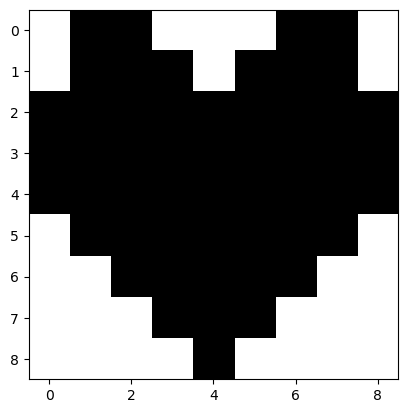

In [2]:
template_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heart_template.png").convert("L")
template_img = torch.tensor(np.array(template_img))/255.0
plt.imshow(template_img, cmap='gray')

In [3]:
template_img = template_img.flatten()

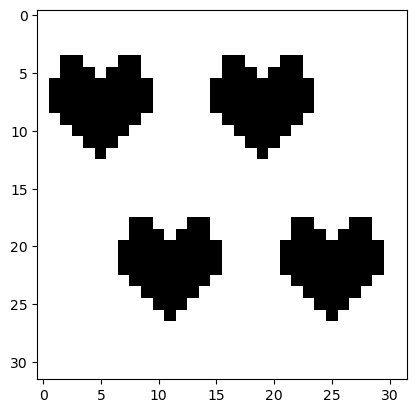

In [4]:
full_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/bars_stripes_cat/heartss.png").convert("L")
full_img = torch.tensor(np.array(full_img))/255.0
plt.imshow(full_img, cmap='gray')

In [5]:
unfold = torch.nn.Unfold(kernel_size=(9,9),stride=3)
img_patches = unfold(full_img.unsqueeze(0).unsqueeze(0))
img_patches = img_patches.squeeze(0).T
print("Number of image patches:", img_patches.shape[0])
print("Single Image Patch Shape:", img_patches.shape[1])

Number of image patches: 64
Single Image Patch Shape: 81


In [6]:
# ex_patch = img_patches[-1].reshape(9,9)
# plt.imshow(ex_patch, cmap='gray')

In [7]:
### Verifying atleast one patch is similar to the template

def find_similar_patches(img_patches, template_img):
    
    similarity = torch.nn.functional.cosine_similarity(img_patches, template_img.unsqueeze(0), dim=1)
    
    similar_patches = []
    for i in range(len(similarity)):
        if similarity[i] > 0.99:  # Adjust threshold as needed
            similar_patches.append(i)

    if len(similar_patches) == 0:
        print("No patches are identical to the template.")
    else:
        print(f"Found {len(similar_patches)} patches that are identical to the template at indices: {similar_patches}")
    
    return similar_patches


similar_patches = find_similar_patches(img_patches, template_img)


Found 1 patches that are identical to the template at indices: [55]


## Getting Wavefunction of Dataset

In [8]:
n_qubits = math.ceil(math.log2(img_patches.shape[1]))
n_ancillas = math.ceil(math.log2(img_patches.shape[0]))
total_qubits = n_qubits + n_ancillas
print("Number of qubits:", n_qubits)
print("Number of ancillas:", n_ancillas)

Number of qubits: 7
Number of ancillas: 6


In [9]:
def prepare_padded_data(dataset):

    n = math.ceil(math.log2(dataset.shape[1]))
    padded_data = torch.zeros((dataset.shape[0], 2**n))
    padded_data[:, :dataset.shape[1]] = dataset

    for d in padded_data:
        eps = 1e-6
        
        if torch.linalg.norm(d) < 1e-8:
            d = torch.full_like(d, eps)
        d /= torch.linalg.norm(d)

    return padded_data

In [10]:
padded_temp_img= prepare_padded_data(template_img.unsqueeze(0)).squeeze(0)
print("Padded Template Image Shape:", padded_temp_img.shape)

Padded Template Image Shape: torch.Size([128])


In [11]:
target_dm = torch.einsum("i,j -> ij", padded_temp_img, padded_temp_img)
target_dm.shape

torch.Size([128, 128])

In [12]:
padded_img_patches = prepare_padded_data(img_patches)
print("Padded Image Patches Shape:", padded_img_patches.shape)

Padded Image Patches Shape: torch.Size([64, 128])


In [13]:
def encode_conditional_state_with_ancilla_last(data,total_qubits):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 16  # because 2^4 = 16 ancilla states

        for j in range(data.shape[0]):
            psi_full[base_index + j] = data[j][i]   

        # psi_full[base_index + 0] = data[0][i]  # |000⟩ ancilla
        # psi_full[base_index + 1] = data[1][i]  # |001⟩ ancilla
        # psi_full[base_index + 2] = data[2][i]
        # psi_full[base_index + 3] = data[3][i]
        # psi_full[base_index + 4] = data[4][i]
        # psi_full[base_index + 5] = data[5][i]
        # psi_full[base_index + 6] = data[6][i]
        # psi_full[base_index + 7] = data[7][i]
        # psi_full[base_index + 8] = data[8][i]
        # psi_full[base_index + 9] = data[9][i]
        # psi_full[base_index + 10] = data[10][i]
        # psi_full[base_index + 11] = data[11][i]
        # psi_full[base_index + 12] = data[12][i]
        # psi_full[base_index + 13] = data[13][i]

    return psi_full / torch.linalg.norm(psi_full)

data_full = encode_conditional_state_with_ancilla_last(padded_img_patches, total_qubits)
data_full.shape

torch.Size([8192])

In [14]:
target_full_dm = torch.einsum("i,j -> ij", data_full, data_full)
target_full_dm.shape

torch.Size([8192, 8192])

## Functions

In [15]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [16]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)
        qml.RY(ising_params1[i],wires=i)
        qml.RZ(ising_params2[i],wires=i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds1 = 6

@qml.qnode(dev,interface="torch",diff_method="backprop")
def circuit(input_params,folds=folds1,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


## Training the Model

In [17]:
initial_params = torch.rand((folds1, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

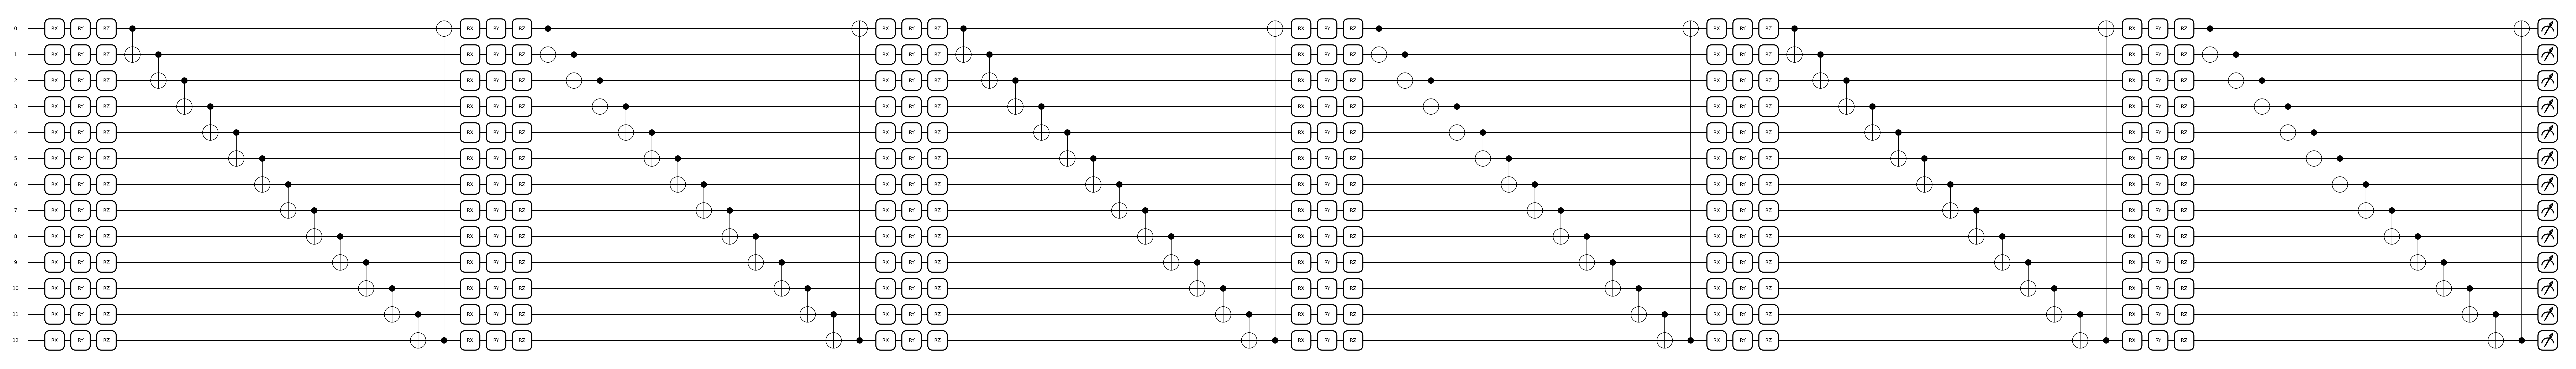

In [18]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [19]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds1, 3* total_qubits), dtype=torch.float32)
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.49418537240620014 Time taken per iter: 0.09218382835388184
Step: 20 Loss: 0.4808975716539399 Time taken per iter: 0.07832813262939453
Step: 30 Loss: 0.46902717840101954 Time taken per iter: 0.09393000602722168
Step: 40 Loss: 0.45789933755353057 Time taken per iter: 0.09056687355041504
Step: 50 Loss: 0.44670560980231067 Time taken per iter: 0.10958218574523926
Step: 60 Loss: 0.43590818385367874 Time taken per iter: 0.08184218406677246
Step: 70 Loss: 0.42182839728166427 Time taken per iter: 0.10078215599060059
Step: 80 Loss: 0.4045164171158622 Time taken per iter: 0.08680582046508789
Step: 90 Loss: 0.38165722557524967 Time taken per iter: 0.09084105491638184
Step: 100 Loss: 0.3572228153008956 Time taken per iter: 0.08667111396789551
Step: 110 Loss: 0.33794139815264324 Time taken per iter: 0.08416485786437988
Step: 120 Loss: 0.3157211556685471 Time taken per iter: 0.08640813827514648
Step: 130 Loss: 0.29092777724238017 Time taken per iter: 0.08508181571960449
Step: 140 Lo

Text(0.5, 1.0, 'Loss Over Epochs')

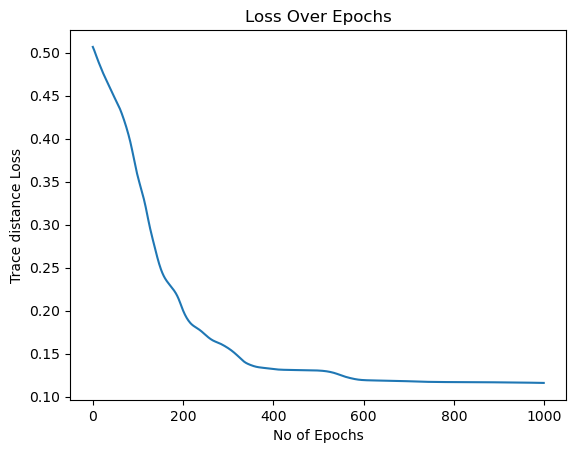

In [20]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [21]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.11598801672896897


In [22]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

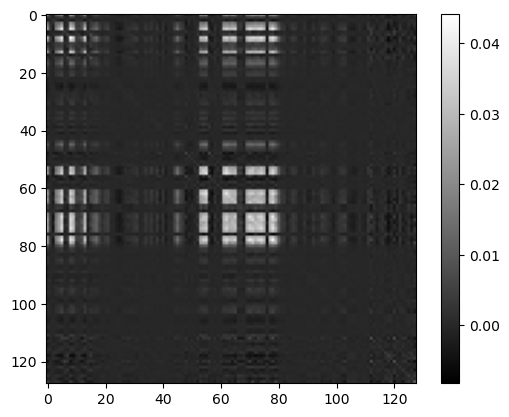

In [23]:
plt.imshow(reduced_dm.real,cmap="grey")
plt.colorbar()

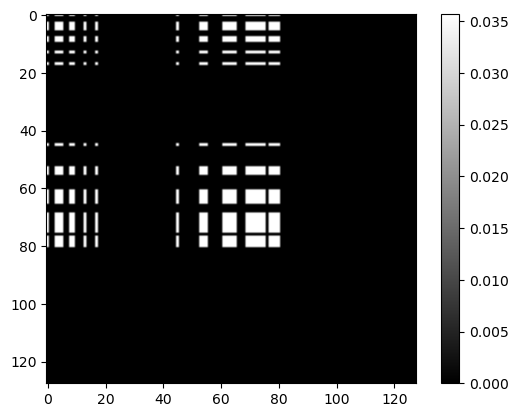

In [24]:
plt.imshow(target_dm.real,cmap="grey")
plt.colorbar()

In [25]:
### NO Training Check
no_training_check_fidelity = torch.abs((psi.conj().T @ data_full)**2)
no_training_check_fidelity

tensor(0.0001)

## Register Basis Training

In [72]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    
    # px_dm = qml.math.dm_from_state_vector(px)
    fidelity = torch.abs((px.conj().T @ py)**2)

    return fidelity

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    # loss = full_psi[0].real
    return -1 * fid_loss

# def vqc(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

#     full_psi = circuit_fn(params).real
#     loss = full_psi[0]
#     return -1 * loss

In [86]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)
        qml.RY(ising_params1[i],wires=n_qubits+i)
        qml.RZ(ising_params2[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[n_qubits+i,n_qubits+i+1])
    qml.CNOT(wires=[n_qubits+total_qubits-1,n_qubits])



dev2 = qml.device("default.qubit",wires=total_qubits)
folds2 = 7

@qml.qnode(dev2,interface="torch",diff_method="backprop")
def reg_circuit(input_params,trained_params=optimal_params,folds=[folds1,folds2],num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(folds[0]):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds[1]):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)

    # qml.QubitDensityMatrix(target_full_dm.conj().T, wires=range(total_qubits))
    # qml.StatePrep(data_full, wires=range(total_qubits)).adjoint
    
    output = qml.state()

    return output


In [87]:
reg_params = torch.rand((folds2, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 16200x1400 with 1 Axes>, <Axes: >)

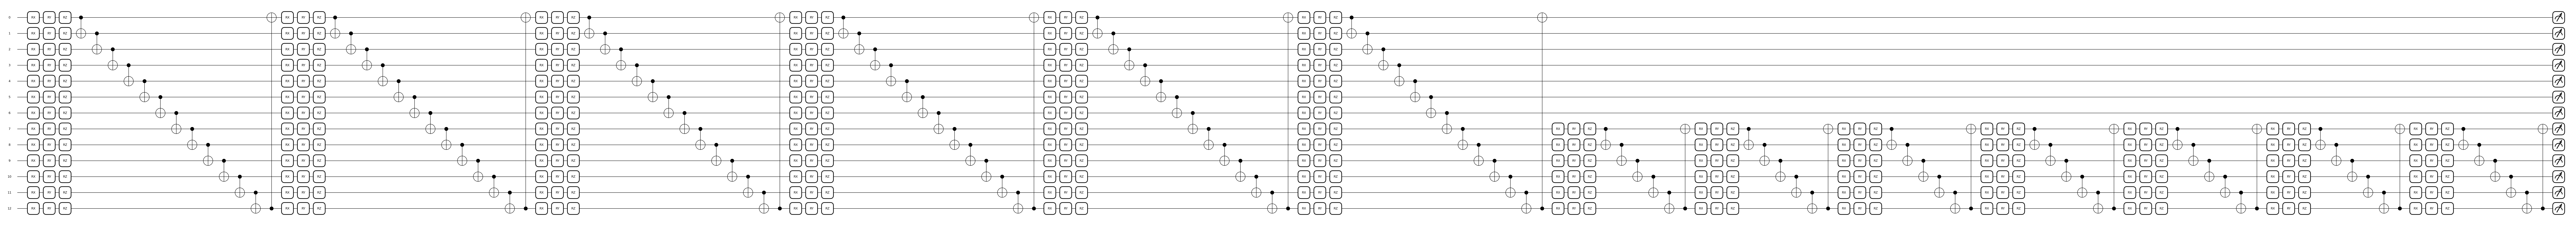

In [88]:
qml.draw_mpl(reg_circuit)(reg_params)

In [89]:
no_training_check = reg_circuit(reg_params)
no_training_check_loss = vqc(reg_circuit,reg_params,data_full)
print("No Training Loss:",no_training_check_loss)

No Training Loss: tensor(-0.0017, grad_fn=<MulBackward0>)


In [90]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.01)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds2, 3 * n_ancillas), dtype=torch.float32)
min_loss = float('inf')
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    # loss_val = vqc(reg_circuit, weights, target_full_dm)
    loss_val = vqc(reg_circuit,weights,data_full)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%2 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(-1 * loss_val.item())

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 2 Loss: -0.0027731896843761206 Time taken per iter: 0.06720733642578125
Step: 4 Loss: -0.0057460651732981205 Time taken per iter: 0.06908106803894043
Step: 6 Loss: -0.0095216641202569 Time taken per iter: 0.06991386413574219
Step: 8 Loss: -0.013782985508441925 Time taken per iter: 0.07085418701171875
Step: 10 Loss: -0.018184790387749672 Time taken per iter: 0.0729978084564209
Step: 12 Loss: -0.022459443658590317 Time taken per iter: 0.06909704208374023
Step: 14 Loss: -0.026466216892004013 Time taken per iter: 0.07131004333496094
Step: 16 Loss: -0.03013109415769577 Time taken per iter: 0.0707399845123291
Step: 18 Loss: -0.03344535082578659 Time taken per iter: 0.06966900825500488
Step: 20 Loss: -0.03649827092885971 Time taken per iter: 0.06792998313903809
Step: 22 Loss: -0.03938182070851326 Time taken per iter: 0.06851983070373535
Step: 24 Loss: -0.0421069897711277 Time taken per iter: 0.0679931640625
Step: 26 Loss: -0.044636644423007965 Time taken per iter: 0.06733274459838867
St

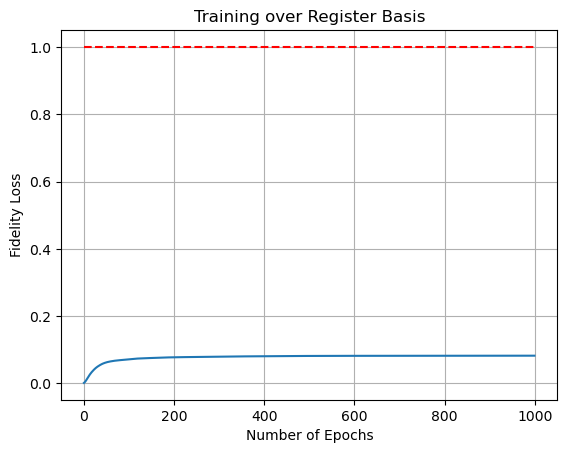

In [93]:
plt.plot(reg_loss_history)
plt.hlines(y=[1.0],xmin=0,xmax=len(reg_loss_history),colors='r',linestyles='dashed',label='Ideal Fidelity')
plt.xlabel("Number of Epochs")
plt.ylabel("Fidelity Loss")
plt.title("Training over Register Basis")
plt.grid(True)
plt.show()

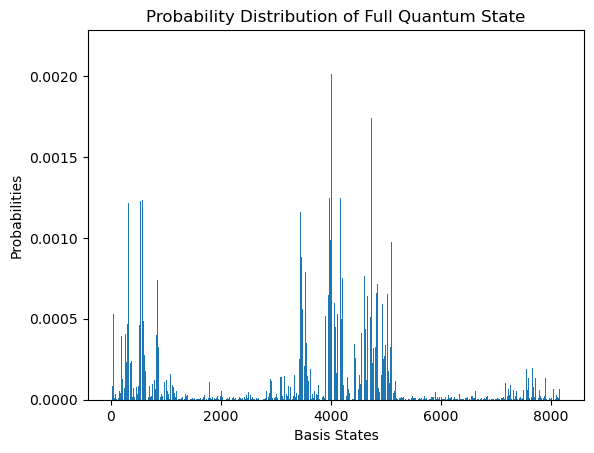

In [104]:
full_psi = reg_circuit(optimal_reg_params)

plt.bar(range(2**total_qubits), torch.abs(full_psi)**2)
plt.xlabel("Basis States")
plt.ylabel("Probabilities")
plt.title("Probability Distribution of Full Quantum State")
plt.show()

## Obtaining the location of heart

In [100]:
@qml.qnode(dev2, interface="torch")
def trained_circuit(qcbm_params,reg_params,folds=[folds1,folds2],num_qubits=n_qubits,total_qubits=total_qubits):

    for i in range(folds[0]):
        qcbm_circuit(params=qcbm_params[i],total_qubits=total_qubits)

    for i in range(folds[1]):
        vqc_circuit(params=reg_params[i],total_qubits=n_ancillas)

    return qml.state()

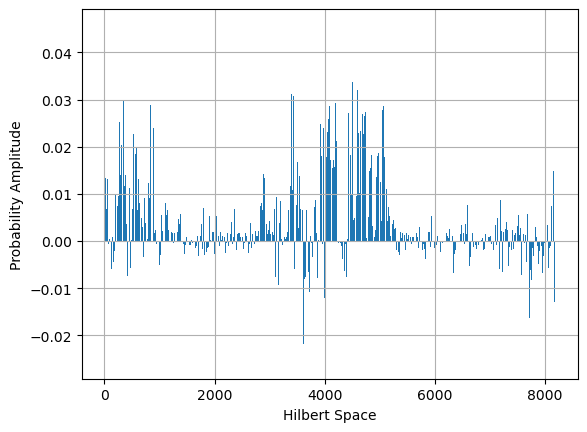

In [105]:
output = trained_circuit(optimal_params,optimal_reg_params).real

plt.bar(range(len(output)),output)
plt.xlabel("Hilbert Space")
plt.ylabel("Probability Amplitude")
plt.grid(True)
plt.show()

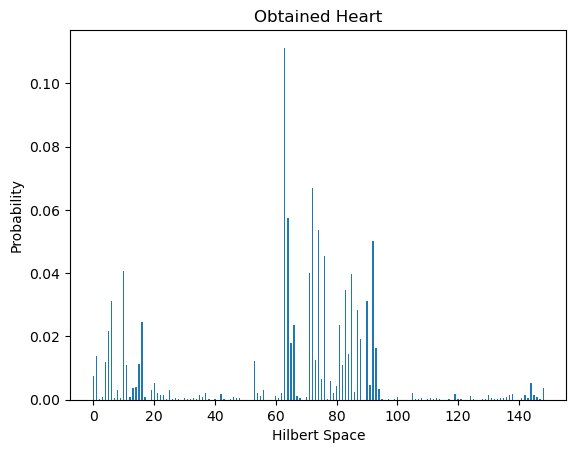

In [ ]:
image = output[::55]
image /= torch.linalg.norm(image)

w, x = 0.4, np.arange(len(image))
plt.bar(x, np.abs(image)**2, w)

plt.xlabel('Hilbert Space')
plt.ylabel('Probability')
plt.title("Obtained Heart")
plt.show()

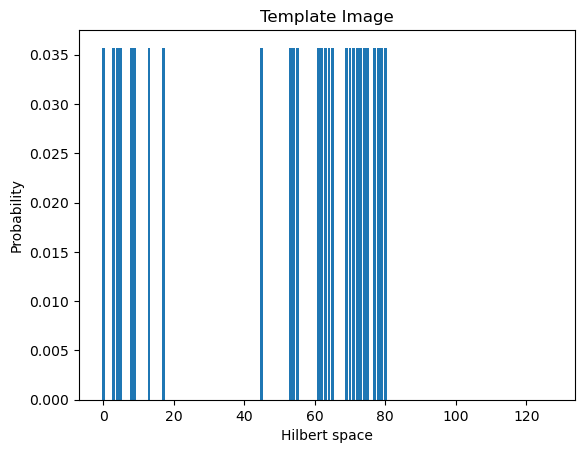

In [107]:
w, x = 0.4, np.arange(len(padded_temp_img))

plt.bar(x, np.abs(padded_temp_img)**2)
plt.xlabel("Hilbert space")
plt.ylabel("Probability")
plt.title("Template Image")
plt.show()